In [1]:
import requests
import os
if not os.path.exists('parquet_queries.py'):
  print('Downloading parquet_queries.py')
  url = 'https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/notebooks/parquet_queries.py'
  response = requests.get(url)
  with open('parquet_queries.py', 'w') as f:
      f.write(response.text)

In [2]:
from parquet_queries import create_time_filter, create_bbox_filter, query_unique_value, plot_spatial_extent, get_spatial_extent, get_temporal_extent, get_schema_metadata
import pyarrow.parquet as pq
import pyarrow.dataset as pds
import pyarrow as pa
import os
import pandas as pd
import pyarrow.compute as pc

In [3]:
import boto3
BUCKET_OPTIMISED_DEFAULT="imos-data-lab-optimised"

def list_folders_with_parquet(bucket_name, prefix):
    s3 = boto3.client('s3')

    # Ensure the prefix ends with a slash to list "folders"
    if not prefix.endswith('/'):
        prefix += '/'

    response = s3.list_objects_v2(
        Bucket=bucket_name,
        Prefix=prefix,
        Delimiter='/'
    )

    folders = []
    for prefix in response.get('CommonPrefixes', []):
        folder_path = prefix['Prefix']
        if folder_path.endswith('.parquet/'):
            # Extracting the folder name without the prefix
            folder_name = folder_path[len(prefix) - 1:]
            folders.append(folder_name)

    return folders

# Example usage
bucket_name = BUCKET_OPTIMISED_DEFAULT
prefix = 'parquet/loz_test'

folders_with_parquet = list_folders_with_parquet(bucket_name, prefix)

folders_with_parquet

['parquet/loz_test/aatams_acoustic_tagging.parquet/',
 'parquet/loz_test/ardc_wave_nrt.parquet/',
 'parquet/loz_test/argo_core.parquet/',
 'parquet/loz_test/soop_xbt_nrt.parquet/']

In [4]:
BUCKET_OPTIMISED_DEFAULT="imos-data-lab-optimised"

catalog = dict()
for dataset in folders_with_parquet:
    dname = f"s3://{BUCKET_OPTIMISED_DEFAULT}/{dataset}"
    
    metadata = get_schema_metadata(dname)  # schema metadata

    path_parts = dataset.strip('/').split('/')
    
    # Get the last part of the path (folder name with extension)
    last_folder_with_extension = path_parts[-1]
    
    # Remove the file extension
    dataset_name = os.path.splitext(last_folder_with_extension)[0]
        
    catalog[dataset_name] = metadata

In [5]:
catalog

{'aatams_acoustic_tagging': {'detection_timestamp': {'type': 'timestamp[ns]',
   'standard_name': 'time',
   'long_name': '',
   'units': 's',
   'comments': ''},
  'transmitter_id': {'type': 'string',
   'standard_name': '',
   'long_name': '',
   'units': '',
   'comments': ''},
  'installation_name': {'type': 'string',
   'standard_name': '',
   'long_name': '',
   'units': '',
   'comments': ''},
  'station_name': {'type': 'string',
   'standard_name': '',
   'long_name': '',
   'units': '',
   'comments': ''},
  'receiver_name': {'type': 'string',
   'standard_name': '',
   'long_name': '',
   'units': '',
   'comments': ''},
  'latitude': {'type': 'double',
   'standard_name': '',
   'long_name': '',
   'units': '',
   'comments': ''},
  'longitude': {'type': 'double',
   'standard_name': '',
   'long_name': '',
   'units': '',
   'comments': ''},
  'sensor_value': {'type': 'double',
   'standard_name': '',
   'long_name': '',
   'units': '',
   'comments': ''},
  'sensor_unit': 

In [7]:
!pip install fuzzywuzzy
from fuzzywuzzy import fuzz


In [97]:
from fuzzywuzzy import fuzz

def find_datasets_with_standard_name(data_dict, target_standard_name, threshold=80):
    """
    Recursively search a nested dictionary for 'standard_name' keys with values
    that match or closely match the target_standard_name using fuzzy matching.

    Args:
        data_dict (dict): The nested dictionary to search.
        target_standard_name (str): The target value to match.
        threshold (int): The minimum similarity threshold for fuzzy matching (default: 80).

    Returns:
        list: A list of dataset names (main keys) where matches are found.
    """
    matching_datasets = []

    if not isinstance(data_dict, dict):
        return matching_datasets  # Handle unexpected input data types

    for dataset_name, attributes in data_dict.items():
        if not isinstance(attributes, dict):
            continue  # Skip non-dictionary attributes

        for key, value in attributes.items():
            if isinstance(value, dict) and 'standard_name' in value:
                # Check for standard_name match using fuzzy matching
                current_standard_name = value.get('standard_name', '')
                similarity_score = fuzz.partial_ratio(target_standard_name.lower(), current_standard_name.lower())
                if similarity_score >= threshold:
                    matching_datasets.append(dataset_name)  # Add dataset name to list

            # Recursively search deeper
            matching_datasets.extend(find_datasets_with_standard_name(value, target_standard_name, threshold))

    return list(set(matching_datasets)) 


# Example usage:
target_name = "salinity"
result = find_datasets_with_standard_name(catalog, target_name)
print("Dataset Name:", result)

Dataset Name: ['argo_core']


In [100]:
from fuzzywuzzy import fuzz

def find_datasets_with_attribute(data_dict, target_value, target_key='standard_name', threshold=80):
    """
    Recursively search a nested dictionary for 'standard_name' keys with values
    that match or closely match the target_value using fuzzy matching.

    Args:
        data_dict (dict): The nested dictionary to search.
        target_value (str): The target value to match.
        threshold (int): The minimum similarity threshold for fuzzy matching (default: 80).

    Returns:
        list: A list of dataset names (main keys) where matches are found.
    """
    matching_datasets = []

    if not isinstance(data_dict, dict):
        return matching_datasets  # Handle unexpected input data types

    for dataset_name, attributes in data_dict.items():
        if not isinstance(attributes, dict):
            continue  # Skip non-dictionary attributes

        for key, value in attributes.items():
            if isinstance(value, dict) and target_key in value:
                # Check for standard_name match using fuzzy matching
                current_standard_name = value.get(target_key, '')
                similarity_score = fuzz.partial_ratio(target_value.lower(), current_standard_name.lower())
                if similarity_score >= threshold:
                    matching_datasets.append(dataset_name)  # Add dataset name to list

            # Recursively search deeper
            matching_datasets.extend(find_datasets_with_attribute(value, target_value, threshold))

    return list(set(matching_datasets)) 


# Example usage:
target_value = "seconds"
result = find_datasets_with_attribute(catalog, target_value, target_key='units')
print("Dataset Name:", result)

Dataset Name: ['ardc_wave_nrt', 'aatams_acoustic_tagging']


In [62]:
class getAodn:
    def __init__(self):#, **kwargs):
        #self.test = kwargs.get('test', 'test')
        self.bucket_name = BUCKET_OPTIMISED_DEFAULT
        self.prefix = 'parquet/loz_test'

        # initialise the class by calling the needed methods
        self.metadata_catalog()

    def metadata_catalog(self):
        folders_with_parquet = list_folders_with_parquet(self.bucket_name, self.prefix)
        
        catalog = dict()
        for dataset in folders_with_parquet:
            dname = f"s3://{self.bucket_name}/{dataset}"
            
            metadata = get_schema_metadata(dname)  # schema metadata
        
            path_parts = dataset.strip('/').split('/')
            
            # Get the last part of the path (folder name with extension)
            last_folder_with_extension = path_parts[-1]
            
            # Remove the file extension
            dataset_name = os.path.splitext(last_folder_with_extension)[0]
                
            catalog[dataset_name] = metadata

        self.catalog = catalog

        return catalog
    
    def list_folders_with_parquet(self):
        s3 = boto3.client('s3')
        prefix = self.prefix
        # Ensure the prefix ends with a slash to list "folders"
        if not prefix.endswith('/'):
            prefix += '/'
    
        response = s3.list_objects_v2(
            Bucket=self.bucket_name,
            Prefix=prefix,
            Delimiter='/'
        )
    
        folders = []
        for prefix in response.get('CommonPrefixes', []):
            folder_path = prefix['Prefix']
            if folder_path.endswith('.parquet/'):
                # Extracting the folder name without the prefix
                folder_name = folder_path[len(prefix) - 1:]
                folders.append(folder_name)
    
        return folders

    def find_datasets_attribute(self,attribute_value, attribute_key='standard_name', threshold=80):
        """
        Recursively search a nested dictionary for 'standard_name' keys with values
        that match or closely match the attribute_key='standard_name', attribute_value using fuzzy matching.

        Args:
            data_dict (dict): The nested dictionary to search.
            attribute_key='standard_name', attribute_value (str): The target value to match.
            threshold (int): The minimum similarity threshold for fuzzy matching (default: 80).

        Returns:
            list: A list of dataset names (main keys) where matches are found.
        """
        matching_datasets = []

        if not isinstance(self.catalog, dict):
            return matching_datasets  # Handle unexpected input data types

        for dataset_name, attributes in self.catalog.items():
            if not isinstance(attributes, dict):
                continue  # Skip non-dictionary attributes

            for key, value in attributes.items():
                if isinstance(value, dict) and attribute_key in value:
                    # Check for standard_name match using fuzzy matching
                    current_standard_name = value.get(attribute_key, '')
                    similarity_score = fuzz.partial_ratio(attribute_value.lower(), current_standard_name.lower())
                    if similarity_score >= threshold:
                        matching_datasets.append(dataset_name)  # Add dataset name to list

                # Recursively search deeper
                matching_datasets.extend(self.find_datasets_attribute(value, attribute_value, attribute_key=attribute_key, threshold=threshold))

        return list(set(matching_datasets)) 

In [63]:
aodn_instance = getAodn()

aodn_instance.list_folders_with_parquet()

['parquet/loz_test/aatams_acoustic_tagging.parquet/',
 'parquet/loz_test/ardc_wave_nrt.parquet/',
 'parquet/loz_test/argo_core.parquet/',
 'parquet/loz_test/soop_xbt_nrt.parquet/']

In [64]:
aodn_instance.find_datasets_attribute('salinity')

TypeError: getAodn.find_datasets_attribute() got multiple values for argument 'attribute_key'

In [40]:
aodn_instance.find_datasets_attribute('wave')

['ardc_wave_nrt']

In [43]:
aodn_instance.find_datasets_with_standard_name('salinity')

['argo_core']

In [85]:
class getAodn:
    def __init__(self):#, **kwargs):
        #self.test = kwargs.get('test', 'test')
        self.bucket_name = BUCKET_OPTIMISED_DEFAULT
        self.prefix = 'parquet/loz_test'

        # initialise the class by calling the needed methods
        self.catalog = self.metadata_catalog()

    def metadata_catalog(self):
        folders_with_parquet = list_folders_with_parquet(self.bucket_name, self.prefix)
        
        catalog = dict()
        for dataset in folders_with_parquet:
            dname = f"s3://{self.bucket_name}/{dataset}"
            
            metadata = get_schema_metadata(dname)  # schema metadata
        
            path_parts = dataset.strip('/').split('/')
            
            # Get the last part of the path (folder name with extension)
            last_folder_with_extension = path_parts[-1]
            
            # Remove the file extension
            dataset_name = os.path.splitext(last_folder_with_extension)[0]
                
            catalog[dataset_name] = metadata

        return catalog
    
    def list_folders_with_parquet(self):
        s3 = boto3.client('s3')
        prefix = self.prefix
        # Ensure the prefix ends with a slash to list "folders"
        if not prefix.endswith('/'):
            prefix += '/'
    
        response = s3.list_objects_v2(
            Bucket=self.bucket_name,
            Prefix=prefix,
            Delimiter='/'
        )
    
        folders = []
        for prefix in response.get('CommonPrefixes', []):
            folder_path = prefix['Prefix']
            if folder_path.endswith('.parquet/'):
                # Extracting the folder name without the prefix
                folder_name = folder_path[len(prefix) - 1:]
                folders.append(folder_name)
    
        return folders

    def find_datasets_with_standard_name(self, target_standard_name, threshold=80):
        """
        Recursively search a nested dictionary for 'standard_name' keys with values
        that match or closely match the target_standard_name using fuzzy matching.

        Args:
            data_dict (dict): The nested dictionary to search.
            target_standard_name (str): The target value to match.
            threshold (int): The minimum similarity threshold for fuzzy matching (default: 80).

        Returns:
            list: A list of dataset names (main keys) where matches are found.
        """
        matching_datasets = []

        if not isinstance(self.catalog, dict):
            return matching_datasets  # Handle unexpected input data types

        for dataset_name, attributes in self.catalog.items():
            if not isinstance(attributes, dict):
                continue  # Skip non-dictionary attributes

            for key, value in attributes.items():
                if isinstance(value, dict) and 'standard_name' in value:
                    # Check for standard_name match using fuzzy matching
                    current_standard_name = value.get('standard_name', '')
                    similarity_score = fuzz.partial_ratio(target_standard_name.lower(), current_standard_name.lower())
                    if similarity_score >= threshold:
                        matching_datasets.append(dataset_name)  # Add dataset name to list

                # Recursively search deeper
                matching_datasets.extend(find_datasets_with_standard_name(value, target_standard_name, threshold))

        return list(set(matching_datasets))

In [86]:
aodn_instance = getAodn()
aodn_instance.list_folders_with_parquet()

['parquet/loz_test/aatams_acoustic_tagging.parquet/',
 'parquet/loz_test/ardc_wave_nrt.parquet/',
 'parquet/loz_test/argo_core.parquet/',
 'parquet/loz_test/soop_xbt_nrt.parquet/']

In [87]:
aodn_instance.find_datasets_with_standard_name('temp')

['argo_core', 'soop_xbt_nrt']

In [157]:
class getAodn:
    def __init__(self):#, **kwargs):
        #self.test = kwargs.get('test', 'test')
        self.bucket_name = BUCKET_OPTIMISED_DEFAULT
        self.prefix = 'parquet/loz_test'

        # initialise the class by calling the needed methods
        self.catalog = self.metadata_catalog()

    def metadata_catalog(self):
        folders_with_parquet = list_folders_with_parquet(self.bucket_name, self.prefix)
        
        catalog = dict()
        for dataset in folders_with_parquet:
            dname = f"s3://{self.bucket_name}/{dataset}"
            
            metadata = get_schema_metadata(dname)  # schema metadata
        
            path_parts = dataset.strip('/').split('/')
            
            # Get the last part of the path (folder name with extension)
            last_folder_with_extension = path_parts[-1]
            
            # Remove the file extension
            dataset_name = os.path.splitext(last_folder_with_extension)[0]
                
            catalog[dataset_name] = metadata

        return catalog
    
    def list_folders_with_parquet(self):
        s3 = boto3.client('s3')
        prefix = self.prefix
        # Ensure the prefix ends with a slash to list "folders"
        if not prefix.endswith('/'):
            prefix += '/'
    
        response = s3.list_objects_v2(
            Bucket=self.bucket_name,
            Prefix=prefix,
            Delimiter='/'
        )
    
        folders = []
        for prefix in response.get('CommonPrefixes', []):
            folder_path = prefix['Prefix']
            if folder_path.endswith('.parquet/'):
                # Extracting the folder name without the prefix
                folder_name = folder_path[len(prefix) - 1:]
                folders.append(folder_name)
    
        return folders

    def find_datasets_with_attribute(self, target_value, target_key='standard_name',data_dict=None, threshold=80):
        """
        Recursively search a nested dictionary for 'standard_name' keys with values
        that match or closely match the target_value using fuzzy matching.
    
        Args:
            data_dict (dict): The nested dictionary to search.
            target_value (str): The target value to match.
            threshold (int): The minimum similarity threshold for fuzzy matching (default: 80).
    
        Returns:
            list: A list of dataset names (main keys) where matches are found.
        """
        matching_datasets = []
        # https://stackoverflow.com/questions/56535948/python-why-cant-you-use-a-self-variable-as-an-optional-argument-in-a-method
        if data_dict == None:
            data_dict = self.catalog
    
        if not isinstance(data_dict, dict):
            return matching_datasets  # Handle unexpected input data types
    
        for dataset_name, attributes in data_dict.items():
            if not isinstance(attributes, dict):
                continue  # Skip non-dictionary attributes
    
            for key, value in attributes.items():
                if isinstance(value, dict) and target_key in value:
                    # Check for standard_name match using fuzzy matching
                    current_standard_name = value.get(target_key, '')
                    similarity_score = fuzz.partial_ratio(target_value.lower(), current_standard_name.lower())
                    if similarity_score >= threshold:
                        matching_datasets.append(dataset_name)  # Add dataset name to list
    
                # Recursively search deeper
                matching_datasets.extend(self.find_datasets_with_attribute(value, target_value, threshold))
    
        return list(set(matching_datasets))

    class get_dataset(getAodn):
        def __init__(self, dataset_name):
            super().__init__()

            self.dname = f"s3://{self.bucket_name}/{self.prefix}/{dataset_name}.parquet/"
            self.parquet_ds = pq.ParquetDataset(dname, partitioning='hive')

        def partition_keys_list(self):
            dataset = pds.dataset(self.dname, format="parquet", partitioning="hive")

            partition_keys = dataset.partitioning.schema
            return partition_keys

        def spatial_extent(self):
            return plot_spatial_extent(self.parquet_ds)

        def get_temporal_extent(self):
            return get_temporal_extent(self.parquet_ds)

        def get_data(self, date_start=None, date_end=None, lat_min=None, lat_max=None, lon_min=None, lon_max=None):
            filter_time = create_time_filter(self.parquet_ds, date_start=date_start, date_end=date_end)
            filter_geo = create_bbox_filter(self.parquet_ds, lat_min=lat_min, lat_max=lat_max, lon_min=lon_min, lon_max=lon_max)


            filter = filter_geo & filter_time
            df = pd.read_parquet(self.dname, engine='pyarrow',filters=filter)
            return df


In [158]:
aodn_instance = getAodn()
#catalog = aodn_instance.metadata_catalog()

In [125]:
aodn_instance.find_datasets_with_attribute('latitude',target_key='standard_name' )

['ardc_wave_nrt', 'argo_core', 'soop_xbt_nrt']

In [142]:
aodn_instance.get_dataset('soop_xbt_nrt').partition_keys_list()

XBT_line: string
timestamp: int32
polygon: string

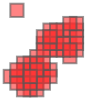

In [143]:
aodn_instance.get_dataset('soop_xbt_nrt').spatial_extent()

In [148]:
aodn_instance.get_dataset('soop_xbt_nrt').get_temporal_extent()

(datetime.datetime(2020, 9, 1, 10, 0), datetime.datetime(2024, 4, 1, 11, 0))

In [159]:
data= aodn_instance.get_dataset('soop_xbt_nrt').get_data(date_start='2023-01-31 10:14:00', 
                                                   date_end='2024-02-01 07:50:00',
                                                   lat_min=-34, lat_max=-32, lon_min=150, lon_max=155)
                                                   


In [160]:
data

,TIME,LATITUDE,LONGITUDE,DEPTH,DEPTH_quality_control,TEMP,TEMP_quality_control,imo_number,ship_name,Callsign,filename,XBT_line,timestamp,polygon
0,2024-01-28 05:41:00,-32.97142,151.99845,0.00,9.0,23.59,3.0,9358022,Pacific-Sun,9HA2479,IMOS_SOOP-XBT_T_20240128T054100Z_PX34_FV00_ID_...,PX34,1704067200,0103000000010000000500000000000000002062400000...
1,2024-01-28 05:41:00,-32.97142,151.99845,0.67,9.0,23.58,3.0,9358022,Pacific-Sun,9HA2479,IMOS_SOOP-XBT_T_20240128T054100Z_PX34_FV00_ID_...,PX34,1704067200,0103000000010000000500000000000000002062400000...
2,2024-01-28 05:41:00,-32.97142,151.99845,1.34,9.0,23.57,3.0,9358022,Pacific-Sun,9HA2479,IMOS_SOOP-XBT_T_20240128T054100Z_PX34_FV00_ID_...,PX34,1704067200,0103000000010000000500000000000000002062400000...
3,2024-01-28 05:41:00,-32.97142,151.99845,2.01,9.0,23.56,3.0,9358022,Pacific-Sun,9HA2479,IMOS_SOOP-XBT_T_20240128T054100Z_PX34_FV00_ID_...,PX34,1704067200,0103000000010000000500000000000000002062400000...
4,2024-01-28 05:41:00,-32.97142,151.99845,2.68,9.0,23.54,3.0,9358022,Pacific-Sun,9HA2479,IMOS_SOOP-XBT_T_20240128T054100Z_PX34_FV00_ID_...,PX34,1704067200,0103000000010000000500000000000000002062400000...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14188,2024-01-28 21:01:00,-33.20854,154.99796,1107.43,9.0,36.26,4.0,9358022,Pacific-Sun,9HA2479,IMOS_SOOP-XBT_T_20240128T210100Z_PX34_FV00_ID_...,PX34,1704067200,0103000000010000000500000000000000002062400000...
14189,2024-01-28 21:01:00,-33.20854,154.99796,1108.17,9.0,36.26,4.0,9358022,Pacific-Sun,9HA2479,IMOS_SOOP-XBT_T_20240128T210100Z_PX34_FV00_ID_...,PX34,1704067200,0103000000010000000500000000000000002062400000...
14190,2024-01-28 21:01:00,-33.20854,154.99796,1108.91,9.0,36.26,4.0,9358022,Pacific-Sun,9HA2479,IMOS_SOOP-XBT_T_20240128T210100Z_PX34_FV00_ID_...,PX34,1704067200,0103000000010000000500000000000000002062400000...
14191,2024-01-28 21:01:00,-33.20854,154.99796,1109.65,9.0,36.26,4.0,9358022,Pacific-Sun,9HA2479,IMOS_SOOP-XBT_T_20240128T210100Z_PX34_FV00_ID_...,PX34,1704067200,0103000000010000000500000000000000002062400000...


In [171]:
class getAodn:
    def __init__(self):
        self.bucket_name = BUCKET_OPTIMISED_DEFAULT
        self.prefix = 'parquet/loz_test'

    class metadata(getAodn):
        def __init__(self):
            super().__init__()
            # initialise the class by calling the needed methods
            self.catalog = self.metadata_catalog()
            
        def metadata_catalog(self):
            folders_with_parquet = list_folders_with_parquet(self.bucket_name, self.prefix)
            
            catalog = dict()
            for dataset in folders_with_parquet:
                dname = f"s3://{self.bucket_name}/{dataset}"
                
                metadata = get_schema_metadata(dname)  # schema metadata
            
                path_parts = dataset.strip('/').split('/')
                
                # Get the last part of the path (folder name with extension)
                last_folder_with_extension = path_parts[-1]
                
                # Remove the file extension
                dataset_name = os.path.splitext(last_folder_with_extension)[0]
                    
                catalog[dataset_name] = metadata
    
            return catalog
        
        def list_folders_with_parquet(self):
            s3 = boto3.client('s3')
            prefix = self.prefix
            # Ensure the prefix ends with a slash to list "folders"
            if not prefix.endswith('/'):
                prefix += '/'
        
            response = s3.list_objects_v2(
                Bucket=self.bucket_name,
                Prefix=prefix,
                Delimiter='/'
            )
        
            folders = []
            for prefix in response.get('CommonPrefixes', []):
                folder_path = prefix['Prefix']
                if folder_path.endswith('.parquet/'):
                    # Extracting the folder name without the prefix
                    folder_name = folder_path[len(prefix) - 1:]
                    folders.append(folder_name)
        
            return folders
    
        def find_datasets_with_attribute(self, target_value, target_key='standard_name',data_dict=None, threshold=80):
            """
            Recursively search a nested dictionary for 'standard_name' keys with values
            that match or closely match the target_value using fuzzy matching.
        
            Args:
                data_dict (dict): The nested dictionary to search.
                target_value (str): The target value to match.
                threshold (int): The minimum similarity threshold for fuzzy matching (default: 80).
        
            Returns:
                list: A list of dataset names (main keys) where matches are found.
            """
            matching_datasets = []
            # https://stackoverflow.com/questions/56535948/python-why-cant-you-use-a-self-variable-as-an-optional-argument-in-a-method
            if data_dict == None:
                data_dict = self.catalog
        
            if not isinstance(data_dict, dict):
                return matching_datasets  # Handle unexpected input data types
        
            for dataset_name, attributes in data_dict.items():
                if not isinstance(attributes, dict):
                    continue  # Skip non-dictionary attributes
        
                for key, value in attributes.items():
                    if isinstance(value, dict) and target_key in value:
                        # Check for standard_name match using fuzzy matching
                        current_standard_name = value.get(target_key, '')
                        similarity_score = fuzz.partial_ratio(target_value.lower(), current_standard_name.lower())
                        if similarity_score >= threshold:
                            matching_datasets.append(dataset_name)  # Add dataset name to list
        
                    # Recursively search deeper
                    matching_datasets.extend(self.find_datasets_with_attribute(value, target_value, threshold))
        
            return list(set(matching_datasets))

    class get_dataset(getAodn):
        def __init__(self, dataset_name):
            super().__init__()

            self.dname = f"s3://{self.bucket_name}/{self.prefix}/{dataset_name}.parquet/"
            self.parquet_ds = pq.ParquetDataset(dname, partitioning='hive')

        def partition_keys_list(self):
            dataset = pds.dataset(self.dname, format="parquet", partitioning="hive")

            partition_keys = dataset.partitioning.schema
            return partition_keys

        def spatial_extent(self):
            return plot_spatial_extent(self.parquet_ds)

        def get_temporal_extent(self):
            return get_temporal_extent(self.parquet_ds)

        def get_data(self, date_start=None, date_end=None, lat_min=None, lat_max=None, lon_min=None, lon_max=None):
            filter_time = create_time_filter(self.parquet_ds, date_start=date_start, date_end=date_end)
            filter_geo = create_bbox_filter(self.parquet_ds, lat_min=lat_min, lat_max=lat_max, lon_min=lon_min, lon_max=lon_max)


            filter = filter_geo & filter_time
            df = pd.read_parquet(self.dname, engine='pyarrow',filters=filter)
            return df


In [172]:
aodn_instance = getAodn()

In [177]:
aodn_instance.metadata().metadata_catalog()

{'aatams_acoustic_tagging': {'detection_timestamp': {'type': 'timestamp[ns]',
   'standard_name': 'time',
   'long_name': '',
   'units': 's',
   'comments': ''},
  'transmitter_id': {'type': 'string',
   'standard_name': '',
   'long_name': '',
   'units': '',
   'comments': ''},
  'installation_name': {'type': 'string',
   'standard_name': '',
   'long_name': '',
   'units': '',
   'comments': ''},
  'station_name': {'type': 'string',
   'standard_name': '',
   'long_name': '',
   'units': '',
   'comments': ''},
  'receiver_name': {'type': 'string',
   'standard_name': '',
   'long_name': '',
   'units': '',
   'comments': ''},
  'latitude': {'type': 'double',
   'standard_name': '',
   'long_name': '',
   'units': '',
   'comments': ''},
  'longitude': {'type': 'double',
   'standard_name': '',
   'long_name': '',
   'units': '',
   'comments': ''},
  'sensor_value': {'type': 'double',
   'standard_name': '',
   'long_name': '',
   'units': '',
   'comments': ''},
  'sensor_unit': 

In [179]:
aodn_instance.metadata().find_datasets_with_attribute('temp',target_key='standard_name' )

['argo_core', 'soop_xbt_nrt']

In [174]:
aodn_instance.get_dataset('soop_xbt_nrt').get_temporal_extent()

(datetime.datetime(2020, 9, 1, 10, 0), datetime.datetime(2024, 4, 1, 11, 0))

In [181]:
df = aodn_instance.get_dataset('soop_xbt_nrt').get_data(date_start='2023-01-31 10:14:00', 
                                                   date_end='2024-02-01 07:50:00',
                                                   lat_min=-34, lat_max=-32, lon_min=150, lon_max=155)
                                                   


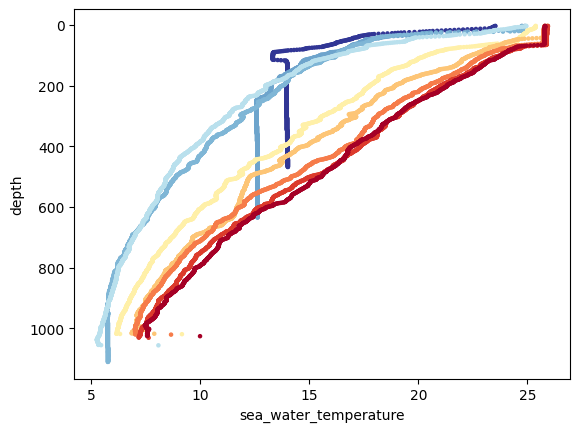

In [182]:
df[df['TEMP_quality_control'] == 1].sort_values('TIME').plot.scatter(x='TEMP', y='DEPTH', c='TIME', 
                                                                     xlabel=metadata['TEMP']['standard_name'],
                                                                     ylabel=metadata['DEPTH']['standard_name'],
                                                                     cmap='RdYlBu_r', marker='.', linestyle="None").invert_yaxis()